In [1]:
!pip install ultralytics -qq

# Object Detecion
import cv2
from ultralytics import YOLO
#plots
import matplotlib.pyplot as plt
import seaborn as sns

#basics
import pandas as pd
import numpy as np
import os
import subprocess

from tqdm.notebook import tqdm

# Display image and videos
import IPython
from IPython.display import Video, display
%matplotlib inline


import urllib.request
import shutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.7/778.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.1 MB/s eta 0:00:00


In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive

from google.colab import auth

from oauth2client.client import GoogleCredentials

auth.authenticate_user()

gauth = GoogleAuth()

gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.23 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.9/78.2 GB disk)


In [26]:
from itertools import chain
from glob import glob
from collections import Counter
from pprint import pprint

id2class_map = {
    '0' : 'buffalo',
    '1' : 'elephant',
    '2' : 'rhino',
    '3' : 'zebra'
}

main_path = "/content/drive/MyDrive/african-wildlife"

def print_data_size(folder_type):
    data_size = len(glob(f'{main_path}/{folder_type}/labels/*.txt'))
    print(f'{folder_type} data count: {data_size}')

def print_class_count(folder_type):
    class_list = []
    for file in glob(f'{main_path}/{folder_type}/labels/*.txt'):
        class_list.append([row.split()[0] for row in open(file, "r")])
    counter = Counter(list(chain(*class_list)))
    print(f'-- data class count')
    pprint({f'{k}. {id2class_map[k]}':v for k, v in counter.items()})
    print()

print_data_size('train')
print_class_count('train')
print_data_size('valid')
print_class_count('valid')
print_data_size('test')
print_class_count('test')

train data count: 1052
-- data class count
{'0. buffalo': 399, '1. elephant': 558, '2. rhino': 399, '3. zebra': 575}

valid data count: 225
-- data class count
{'0. buffalo': 89, '1. elephant': 91, '2. rhino': 85, '3. zebra': 114}

test data count: 227
-- data class count
{'0. buffalo': 66, '1. elephant': 99, '2. rhino': 75, '3. zebra': 135}



In [27]:
import os
import cv2
from matplotlib import pyplot as plt

main_path = f"/content/drive/MyDrive/african-wildlife"

def get_bbox_and_label(image_name, data_type='train', main_path=main_path):
    ''' get bbox and label information from label txt files '''

    # read file from path
    lbl_path = os.path.join(main_path, data_type, 'labels', f'{image_name}.txt')
    with open(lbl_path, 'r') as f:
        lines = f.readlines()

    # extract bboxes and labels from the label file
    bboxes = [
        [float(n) for n in line.split()[1:]]
        for line in lines
    ]
    labels = [id2class_map[line.split()[0]] for line in lines]

    return bboxes, labels

def load_image(image_name, data_type='train', main_path=main_path):
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')
    image = cv2.imread(img_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_bbox_coordinates(img, bbox):
    # reference
    # https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924

    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox

    # calculate the coordinates of the bounding box
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2

    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)

    return x_min, y_min, x_max, y_max

class2color_map = {
    'buffalo': (0,255,128),
    'elephant': (255,51,51),
    'rhino': (51,255,255),
    'zebra': (224,102,255)
}

def plot_image(image_name, data_type='train', class2color_map=class2color_map):
    img = load_image(image_name=image_name, data_type=data_type)
    bboxes, labels = get_bbox_and_label(image_name=image_name, data_type=data_type)
    for bbox, label in zip(bboxes, labels):

        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

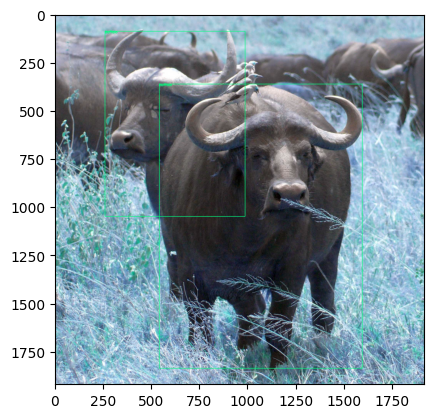

In [28]:
plot_image(image_name='1 (101)')

In [29]:
from ultralytics import YOLO
model = YOLO("yolov9c.pt")
model.info

<bound method Model.info of YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): RepNCSPELAN4(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Sequential(
          (0): RepCSP(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv3): Conv(
              (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (m): Sequential(
              (0): RepBottleneck(
                (cv1): RepConv(
                  (act): SiLU(inplace=True)
                  (conv1): Conv(
                    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                    (act): Identity()
                  )
                  (conv2): Conv(
                    (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                    (act): Identity()
                  )
                )
                (cv2): Conv(
                  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                  (act): SiLU(inplace=True)
                )
              )
            )
          )
          (1): Conv(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
        )
        (cv3): Sequential(
          (0): RepCSP(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv3): Conv(
              (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (m): Sequential(
              (0): RepBottleneck(
                (cv1): RepCon

In [30]:
import yaml

with open(os.path.join(main_path,'coco128.yaml'), 'r' ) as file:
    print(file.read())

In [31]:
data = {
    'train' : '/content/drive/MyDrive/african-wildlife/train',
    'val' : '/content/drive/MyDrive/african-wildlife/test',
    'nc' : 4,
    'names' : [
        'buffalo',
        'elephant',
        'rhino',
        'zebra'
    ]
}

with open('/content/drive/MyDrive/african-wildlife/working/data.yaml','w') as file:
    yaml.dump(data,file)

with open('/content/drive/MyDrive/african-wildlife/working/data.yaml','r') as file:
    print(file.read())

names:
- buffalo
- elephant
- rhino
- zebra
nc: 4
train: /content/drive/MyDrive/african-wildlife/train
val: /content/drive/MyDrive/african-wildlife/test



In [32]:
os.environ["WANDB_MODE"] = "disabled"

model.train(
    data = '/content/drive/MyDrive/african-wildlife/working/data.yaml',
    epochs = 50,
    workers = 1,
    batch = 8,
)

Ultralytics YOLOv8.2.23 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/content/drive/MyDrive/african-wildlife/working/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=1, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

100%|██████████| 755k/755k [00:00<00:00, 24.9MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 123MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/african-wildlife/train/labels... 1052 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1052/1052 [00:50<00:00, 21.03it/s] 


train: New cache created: /content/drive/MyDrive/african-wildlife/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/african-wildlife/test/labels... 227 images, 0 backgrounds, 0 corrupt: 100%|██████████| 227/227 [00:11<00:00, 20.35it/s]


val: New cache created: /content/drive/MyDrive/african-wildlife/test/labels.cache
Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 1 dataloader workers
Logging results to runs/detect/train8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.15G     0.9091      1.625      1.302         23        640: 100%|██████████| 132/132 [01:03<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]

                   all        227        375      0.589      0.513      0.562      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.88G      1.246      1.691      1.518         21        640: 100%|██████████| 132/132 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


                   all        227        375      0.473      0.495      0.425      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.85G      1.325      1.714      1.577         16        640: 100%|██████████| 132/132 [00:57<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


                   all        227        375      0.659      0.472      0.525       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       5.9G       1.33      1.692      1.593         15        640: 100%|██████████| 132/132 [00:58<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]

                   all        227        375       0.48      0.325      0.355      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.87G      1.235      1.544      1.507         23        640: 100%|██████████| 132/132 [00:59<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]

                   all        227        375      0.622      0.612      0.652      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       5.9G      1.178      1.482      1.471         20        640: 100%|██████████| 132/132 [00:58<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


                   all        227        375      0.689      0.619      0.706      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.85G      1.131      1.377      1.452         18        640: 100%|██████████| 132/132 [00:59<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.27it/s]

                   all        227        375      0.763      0.613      0.734      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.89G      1.076      1.245      1.388         11        640: 100%|██████████| 132/132 [00:59<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


                   all        227        375      0.667      0.697      0.747      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.86G      1.085      1.291      1.407         25        640: 100%|██████████| 132/132 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]

                   all        227        375       0.78      0.632      0.758       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       5.9G      1.042      1.215      1.379          9        640: 100%|██████████| 132/132 [00:59<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]

                   all        227        375      0.808      0.794       0.87      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.86G      1.022      1.165      1.364         12        640: 100%|██████████| 132/132 [01:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.52it/s]

                   all        227        375      0.855      0.773      0.868       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       5.9G     0.9832      1.103      1.336         20        640: 100%|██████████| 132/132 [00:59<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]

                   all        227        375      0.836      0.764      0.856      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.86G      0.978      1.067      1.328         22        640: 100%|██████████| 132/132 [00:58<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.07it/s]


                   all        227        375      0.758      0.822      0.854      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       5.9G     0.9414      1.048      1.308         13        640: 100%|██████████| 132/132 [00:59<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]

                   all        227        375      0.872      0.817      0.908      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.86G     0.9069      1.027      1.275         15        640: 100%|██████████| 132/132 [00:58<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]

                   all        227        375      0.813      0.771       0.88      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.89G     0.9047     0.9568      1.277          8        640: 100%|██████████| 132/132 [00:59<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.54it/s]

                   all        227        375      0.867      0.837      0.921      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.87G     0.9072     0.9244      1.278         38        640: 100%|██████████| 132/132 [01:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]

                   all        227        375      0.887      0.835       0.92      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.91G     0.8767     0.9055       1.27         15        640: 100%|██████████| 132/132 [00:59<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.34it/s]

                   all        227        375      0.907      0.872      0.944      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.86G     0.8665      0.889      1.261         15        640: 100%|██████████| 132/132 [00:58<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]

                   all        227        375      0.905      0.853      0.937      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       5.9G     0.8265     0.8794      1.245         14        640: 100%|██████████| 132/132 [00:59<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.53it/s]

                   all        227        375      0.926      0.871      0.935      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.86G     0.8326     0.8303      1.233         14        640: 100%|██████████| 132/132 [00:59<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]

                   all        227        375       0.91      0.859      0.932      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       5.9G     0.8144     0.8229       1.22         25        640: 100%|██████████| 132/132 [00:58<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.23it/s]

                   all        227        375      0.926      0.889       0.95      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.86G     0.8192     0.8247      1.221         15        640: 100%|██████████| 132/132 [00:59<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]

                   all        227        375      0.869      0.838      0.925      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.89G     0.7907     0.8027       1.19         23        640: 100%|██████████| 132/132 [01:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]

                   all        227        375      0.931      0.833       0.93       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.87G     0.7779     0.7731      1.195         16        640: 100%|██████████| 132/132 [00:58<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.20it/s]

                   all        227        375      0.914      0.864       0.95      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       5.9G      0.778     0.7545      1.186         13        640: 100%|██████████| 132/132 [00:59<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.75it/s]

                   all        227        375      0.925      0.855      0.943      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.86G     0.7568     0.7325       1.18         11        640: 100%|██████████| 132/132 [00:59<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


                   all        227        375      0.885      0.857      0.929      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.91G      0.753     0.7422      1.163         10        640: 100%|██████████| 132/132 [00:59<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.59it/s]

                   all        227        375      0.926      0.879      0.947      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.87G     0.7618     0.7108      1.182         17        640: 100%|██████████| 132/132 [00:58<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


                   all        227        375      0.925      0.898      0.957      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       5.9G     0.7185     0.6944      1.153         11        640: 100%|██████████| 132/132 [00:59<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.59it/s]

                   all        227        375      0.905       0.83      0.936      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.86G      0.724     0.6629      1.159         16        640: 100%|██████████| 132/132 [00:58<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]

                   all        227        375      0.895      0.887      0.946      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.91G     0.7239     0.6918      1.163         23        640: 100%|██████████| 132/132 [00:58<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


                   all        227        375      0.934        0.9      0.964      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.88G     0.7201     0.6772      1.157         22        640: 100%|██████████| 132/132 [00:59<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.32it/s]

                   all        227        375      0.951      0.883      0.963      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       5.9G     0.6722     0.6192      1.125         12        640: 100%|██████████| 132/132 [00:58<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]

                   all        227        375      0.954      0.862      0.961      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.87G     0.6697     0.6236      1.132         14        640: 100%|██████████| 132/132 [00:59<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]

                   all        227        375       0.94        0.9      0.966      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       5.9G     0.6814     0.6177      1.144         23        640: 100%|██████████| 132/132 [01:00<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


                   all        227        375      0.918      0.919      0.961      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.87G     0.6736     0.6152       1.12         13        640: 100%|██████████| 132/132 [00:58<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]

                   all        227        375      0.923        0.9      0.958      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       5.9G     0.6532     0.5758      1.114         11        640: 100%|██████████| 132/132 [00:58<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]

                   all        227        375       0.93      0.897      0.967       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.86G     0.6482     0.5741      1.116         13        640: 100%|██████████| 132/132 [00:58<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


                   all        227        375      0.945      0.914      0.966      0.831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       5.9G     0.6212     0.5518      1.099         21        640: 100%|██████████| 132/132 [00:59<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.55it/s]

                   all        227        375      0.942      0.903      0.959      0.814


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
      41/50      5.87G     0.5311     0.4468      1.026          4        640: 100%|██████████| 132/132 [01:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]

                   all        227        375      0.961      0.887      0.956      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       5.9G     0.5202     0.4007      1.013          6        640: 100%|██████████| 132/132 [00:58<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


                   all        227        375      0.953      0.874      0.959      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.87G     0.5084     0.3947      1.004          6        640: 100%|██████████| 132/132 [01:00<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]

                   all        227        375      0.954      0.908      0.967      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.89G     0.4991     0.3659     0.9885          7        640: 100%|██████████| 132/132 [00:59<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.88it/s]

                   all        227        375      0.955      0.921      0.964      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.85G     0.4822     0.3652     0.9897          8        640: 100%|██████████| 132/132 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]

                   all        227        375      0.944      0.888      0.966      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       5.9G     0.4599      0.337     0.9658          5        640: 100%|██████████| 132/132 [01:02<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]

                   all        227        375       0.97      0.889       0.97      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.86G     0.4631     0.3439       0.97          8        640: 100%|██████████| 132/132 [00:59<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]

                   all        227        375      0.956      0.914      0.971      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       5.9G     0.4491     0.3427     0.9689          6        640: 100%|██████████| 132/132 [00:58<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]

                   all        227        375      0.965      0.909      0.972      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.86G     0.4359     0.3244      0.951          8        640: 100%|██████████| 132/132 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.57it/s]

                   all        227        375      0.957      0.911      0.972      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.89G     0.4275     0.3099     0.9423          6        640: 100%|██████████| 132/132 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]

                   all        227        375      0.966      0.899      0.973      0.849



50 epochs completed in 0.956 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 51.6MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics YOLOv8.2.23 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25322332 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


                   all        227        375      0.966      0.899      0.973       0.85
               buffalo        227         66       0.97      0.864       0.97      0.879
              elephant        227         99      0.974      0.919      0.974       0.81
                 rhino        227         75      0.986      0.925      0.979      0.917
                 zebra        227        135      0.935      0.889      0.968      0.794
Speed: 0.5ms preprocess, 12.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79dc60cc3310>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [34]:
from ultralytics import YOLO

model = YOLO('/content/runs/detect/train8/weights/best.pt')

In [41]:
def plot_pred_image(image_name, id2class_map=id2class_map, class2color_map=class2color_map):
    image_path = os.path.join(main_path, 'test', 'images', f'{image_name}.jpg')

    # get plot elements (bbox, labels) from `predict()` results
    results = model.predict(image_path)
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]
    for bbox, label in zip(bboxes, labels):
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = [int(n) for n in bbox]

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

In [42]:
def label_image(image_path):
    # Görüntüyü yükleme
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image file '{image_path}' not found or could not be loaded.")

    # Görüntü boyutlarını alma
    original_shape = image.shape[:2]  # (height, width)

    # YOLO modelini kullanarak tahminler yapma
    results = model(image)

    # Tahmin edilen nesneleri al
    labels = results[0].boxes.data.cpu().numpy()  # YOLOv8 için results[0].boxes.data
    predicted_labels = []

    for label in labels:
        x_min, y_min, x_max, y_max, confidence, class_id = label[:6]  # İlk 6 elemanı al
        x_center = (x_min + x_max) / 2 / original_shape[1]
        y_center = (y_min + y_max) / 2 / original_shape[0]
        width = (x_max - x_min) / original_shape[1]
        height = (y_max - y_min) / original_shape[0]
        predicted_labels.append(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return predicted_labels

def save_labels(labels, label_path):
    # Etiketleri dosyaya yazma
    with open(label_path, 'w') as file:
        for label in labels:
            file.write(f"{label}\n")



0: 448x640 1 zebra, 38.0ms
Speed: 2.4ms preprocess, 38.0ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)
The predicted labels for the image are saved to: /content/drive/MyDrive/african-wildlife/test/labels/zebra.txt
prediction ↓

image 1/1 /content/drive/MyDrive/african-wildlife/test/images/zebra.jpg: 448x640 1 zebra, 38.0ms
Speed: 2.3ms preprocess, 38.0ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)


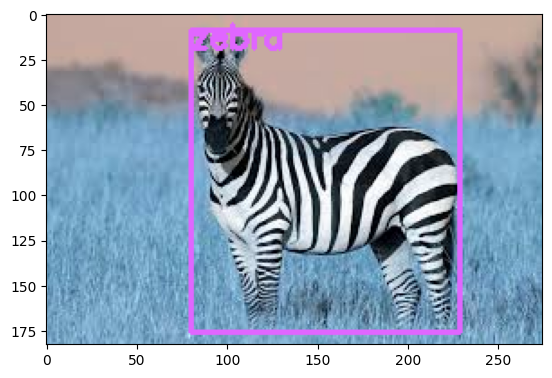

actual image ↓


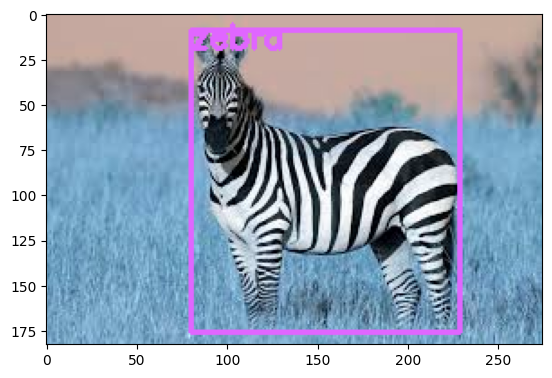

In [48]:
# Örnek kullanım
image_path = '/content/drive/MyDrive/african-wildlife/test/images/zebra.jpg'
label_path = '/content/drive/MyDrive/african-wildlife/test/labels/zebra.txt'

# Etiket klasörünün var olup olmadığını kontrol et ve gerekirse oluştur
os.makedirs(os.path.dirname(label_path), exist_ok=True)

try:
    predicted_labels = label_image(image_path)
    save_labels(predicted_labels, label_path)
    print(f'The predicted labels for the image are saved to: {label_path}')
except Exception as e:
    print(f"Error: {e}")

image_name = 'zebra'
print('prediction ↓')
plot_pred_image(image_name=image_name)
print('actual image ↓')
plot_image(image_name=image_name, data_type='test')
